# Target Ensemble

Apart from the main target, there are actually many auxilliary targets in the dataset. 

These targets are fundamentally related to the main target which make them potentially helpful to model. And because these targets have a wide range of correlations to the main targets, it means that we could potentially build some nice ensembles to boost our performance. 

In this notebook, we will 
1. Explore the auxilliary targets
2. Select our favorite targets to include in the ensemble
3. Create an ensemble of models trained on different targets
4. Pickle and upload our ensemble model

In [59]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle seaborn

# Inline plots
%matplotlib inline


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## 1. Auxilliary Targets

Let's start by taking a look at the different targets in the training data.

In [60]:
import pandas as pd
import json
from numerapi import NumerAPI

# Download data
napi = NumerAPI()
napi.download_dataset("v4.2/train_int8.parquet");
napi.download_dataset("v4.2/features.json");

# Load data
feature_metadata = json.load(open("v4.2/features.json")) 
feature_cols = feature_metadata["feature_sets"]["medium"]
target_cols = feature_metadata["targets"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + target_cols)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data (higher memory usage, slower model training, potentially better performance)
train = train[train["era"].isin(train["era"].unique()[::4])]

# Print target columns
train[["era"] + target_cols]

2023-08-30 17:28:47,174 INFO numerapi.utils: target file already exists
2023-08-30 17:28:47,176 INFO numerapi.utils: download complete
2023-08-30 17:28:47,631 INFO numerapi.utils: target file already exists
2023-08-30 17:28:47,632 INFO numerapi.utils: download complete


,era,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,...,target_bravo_v4_20,target_bravo_v4_60,target_charlie_v4_20,target_charlie_v4_60,target_delta_v4_20,target_delta_v4_60,target_echo_v4_20,target_echo_v4_60,target_jeremy_v4_20,target_jeremy_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.250000,0.250000,0.000000,0.500000,0.250000,0.250000,0.000000,0.250000,0.250000,...,0.250000,0.000000,0.500000,0.250000,0.250000,0.000000,0.250000,0.000000,0.250000,0.250000
n003bee128c2fcfc,0001,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,1.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,1.000000
n0048ac83aff7194,0001,0.250000,0.500000,0.250000,0.500000,0.500000,0.500000,0.250000,0.500000,0.250000,...,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000
n00691bec80d3e02,0001,0.750000,0.750000,0.500000,0.500000,0.750000,0.750000,0.500000,0.750000,0.500000,...,0.750000,0.500000,0.750000,0.750000,0.500000,0.500000,0.750000,0.500000,0.500000,0.500000
n00b8720a2fdc4f2,0001,0.500000,0.750000,0.500000,0.750000,0.750000,0.750000,0.500000,0.500000,0.500000,...,0.750000,0.500000,0.750000,0.500000,0.750000,0.500000,0.750000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.250000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,...,0.000000,0.250000,0.000000,0.250000,0.250000,0.500000,0.000000,0.250000,0.000000,0.250000
nffc7d24176548a4,0573,0.500000,0.500000,0.250000,0.500000,0.250000,0.500000,0.500000,0.500000,0.250000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.250000
nffc9844c1c7a6a9,0573,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.250000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.250000,0.500000,0.500000,0.500000,0.500000,0.500000


### The main target

First thing to note is that `target` is just an alias for `target_cyrus_v4_20`, so we can drop this column for the rest of the notebook. 

In [61]:
# Drop `target` column
assert train["target"].equals(train["target_cyrus_v4_20"])
target_names = target_cols[1:]
targets_df = train[["era"] + target_names]

### Target names

At a high level, each target represents a different kind of stock market return
- the `name` represents the type of stock market return (eg. residual to market/country/sector vs market/country/style)
- the `_20` or `_60` suffix denotes the time horizon of the target (ie. 20 vs 60 market days)

The reason why `target_cyrus_v4_20` is our main target is because it most closely matches the type of returns we want for our hedge fund. Just like how we are always in search for better features to include in the dataset, we are also always in search for better targets to make our main target. During our research, we often come up with targets we like but not as much as the main target, and these are instead released as auxilliary targets.

In [62]:
# Print target names grouped by name and time horizon
pd.set_option('display.max_rows', 100)
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
names = [t[7:-6] for t in t20s]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
nomi,target_nomi_v4_20,target_nomi_v4_60
tyler,target_tyler_v4_20,target_tyler_v4_60
victor,target_victor_v4_20,target_victor_v4_60
ralph,target_ralph_v4_20,target_ralph_v4_60
waldo,target_waldo_v4_20,target_waldo_v4_60
jerome,target_jerome_v4_20,target_jerome_v4_60
janet,target_janet_v4_20,target_janet_v4_60
ben,target_ben_v4_20,target_ben_v4_60
alan,target_alan_v4_20,target_alan_v4_60


### Target values

Note that some targets are binned into 5 bins while others are binned into 7 bins.

Unlike feature values which are integers ranging from 0-4, target values are floats which range from 0-1.

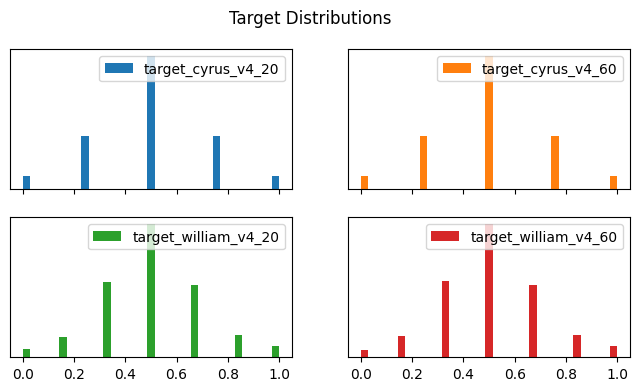

In [63]:
# Plot target distributions
targets_df[["target_cyrus_v4_20", "target_cyrus_v4_60", "target_william_v4_20", "target_william_v4_60"]].plot(kind="hist", bins=35, density=True, figsize=(8, 4), title="Target Distributions", subplots=True, layout=(2, 2), ylabel="", yticks=[]);

It is also important to note that the auxilary targets can be `NaN`, but the primary target will never be `NaN`. Since we are using tree-based models here we won't need to do any special pre-processing.

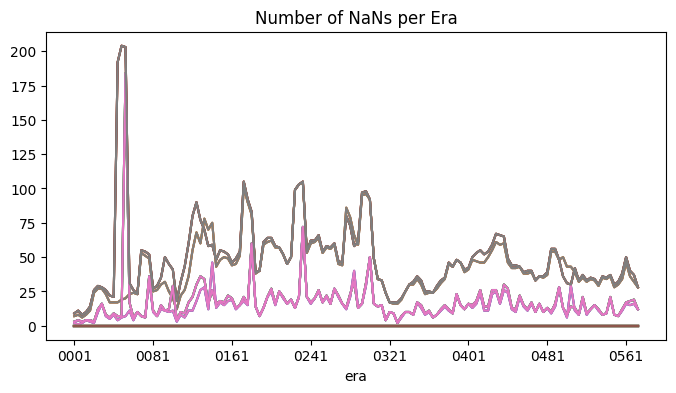

In [64]:
# print number of NaNs per era
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(8, 4), title="Number of NaNs per Era", legend=False);

### Target correlations

The targets have a wide range of correlations with each other even though they are all fundamentally related, which should allow the construction of diverse models that ensemble together nicely.

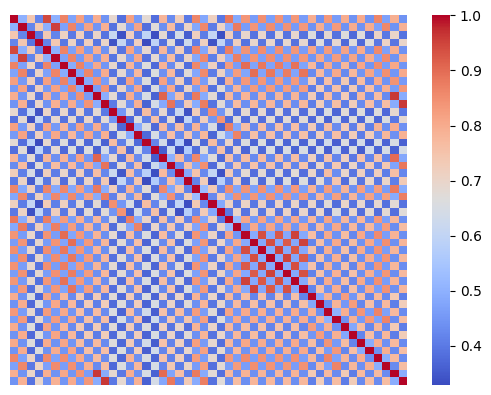

In [65]:
# Plot correlation matrix of targets
import seaborn as sns
sns.heatmap(targets_df[target_names].corr(), cmap="coolwarm", xticklabels=False, yticklabels=False);

Since we are ultimately trying to predict the main target (`target_cyrus_v4_20`), it is perhaps most important to consider each auxilliary target's correlation to it.

In [66]:
targets_df[target_names].corrwith(targets_df["target_cyrus_v4_20"]).sort_values(ascending=False).to_frame("corr_with_cyrus_v4_20")

,corr_with_cyrus_v4_20
target_cyrus_v4_20,1.000000
target_xerxes_v4_20,0.951474
target_caroline_v4_20,0.938870
target_sam_v4_20,0.923488
target_ralph_v4_20,0.898095
target_echo_v4_20,0.853768
target_victor_v4_20,0.841411
target_nomi_v4_20,0.840038
target_william_v4_20,0.837671
target_waldo_v4_20,0.833776


## 2. Target Selection

Our goal is to create an ensemble of models trained on different targets. But which targets should we use?

When deciding which model to ensemble, we should consider a few things:
- The performance of the predictions of the model trained on the target vs the main target
- The correlation between the target and the main target

To keep things simple and fast, let's just arbitrarily pick a few 20-day targets to evaluate.

In [67]:
# Arbitrarily pick a few 20-day target candidates
target_candidates = ["target_cyrus_v4_20", "target_waldo_v4_20", "target_victor_v4_20", "target_xerxes_v4_20"]

### Model training and generating validation predictions

Like usual we will train on the training dataset.

In [68]:
import lightgbm as lgb

models = {}
for target in target_candidates:
    model = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=5,
        num_leaves=2**5-1,
        colsample_bytree=0.1
    )
    model.fit(
        train[feature_cols],
        train[target]
    );
    models[target] = model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 583
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves

Then we will generate predictions on the validation dataset.

In [69]:
# Download validation data 
napi.download_dataset("v4.2/validation_int8.parquet");

# Load the validation data, filtering for data_type == "validation"
validation = pd.read_parquet("v4.2/validation_int8.parquet", columns=["era", "data_type"] + feature_cols + target_cols) 
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample every 4th era to reduce memory usage and speedup validation (suggested for Colab free tier)
# Comment out the line below to use all the data
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Embargo overlapping eras from training data
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

2023-08-30 17:32:20,886 INFO numerapi.utils: target file already exists
2023-08-30 17:32:20,886 INFO numerapi.utils: download complete


In [70]:
# Generate validation predictions for each model
for target in target_candidates:
    validation[f"prediction_{target}"] = models[target].predict(validation[feature_cols])
    
pred_cols = [f"prediction_{target}" for target in target_candidates]
validation[pred_cols]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,prediction_target_cyrus_v4_20,prediction_target_waldo_v4_20,prediction_target_victor_v4_20,prediction_target_xerxes_v4_20
id,,,,
n002a15bc5575bbb,0.507566,0.507919,0.501512,0.506677
n00309caaa0f955e,0.509038,0.515242,0.512600,0.505294
n00576b397182463,0.495131,0.492790,0.493589,0.493629
n00633405d59c6a1,0.500930,0.501813,0.500687,0.498394
n008c2eefc8911c7,0.496661,0.496379,0.496833,0.494594
...,...,...,...,...
nffd5af15959f152,0.489949,0.488280,0.492154,0.488867
nffd9899640fa670,0.503236,0.503446,0.509806,0.504726
nffdc9ed5105d9c3,0.508867,0.512292,0.511857,0.512672


### Evaluating the performance of each model

Now we can evaluate the performance of our models.

In [71]:
from scipy import stats
import numpy as np

def numerai_corr(preds, target):
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    centered_target = target - target.mean()
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    return np.corrcoef(preds_p15, target_p15)[0, 1]

As you can see in the performance chart below, models trained on the auxiliary target are able to predict the main target pretty well, but the model trained on the main target performs the best. 

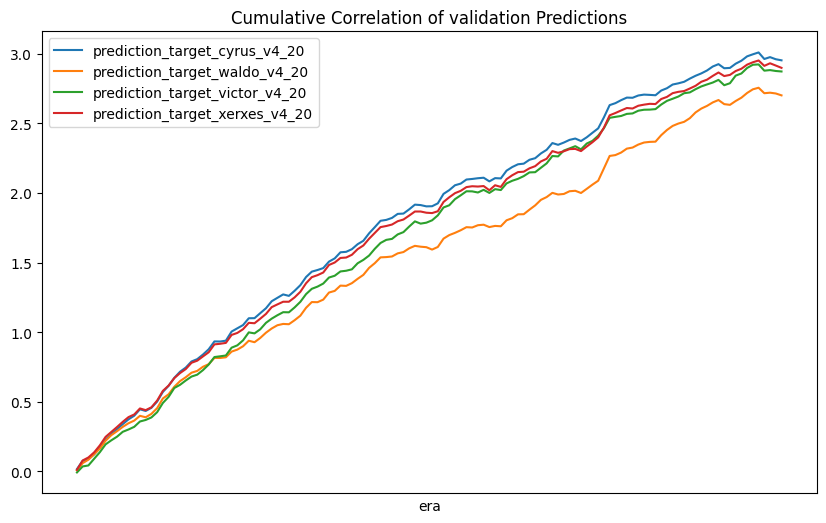

In [72]:
correlations = {}
cumulative_correlations = {}
for target in target_candidates:
    correlations[f"prediction_{target}"] = validation.groupby("era").apply(lambda d: numerai_corr(d[f"prediction_{target}"], d["target"]))
    cumulative_correlations[f"prediction_{target}"] = correlations[f"prediction_{target}"].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of validation Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary metrics below:
- the model trained on `waldo` has by far the lowest mean (0.021784), so even though it is not the most correlated with `cyrus` (81%), it might not help actually help our performance 
- the model trained on `xerxes` has the highest mean (0.023378), but is also very correlated with `cyrus` (94%), so we might not see much effect from ensembling
- the model trained on `victor` has almost the same mean as `xerxes` (0.023168), and is much less correlated with `cyrus` (83%), so looks very promising 

In [73]:
summary_metrics = {}
for target in target_candidates:
    # per era correlation between this target and cyrus 
    mean_corr_with_cryus = validation.groupby("era").apply(lambda d: d[target].corr(d["target_cyrus_v4_20"])).mean()
    # per era correlation between predictions of the model trained on this target and cyrus
    mean = correlations[f"prediction_{target}"].mean()
    std = correlations[f"prediction_{target}"].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[f"prediction_{target}"].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[f"prediction_{target}"]).max()
    summary_metrics[f"prediction_{target}"] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
        "mean_corr_with_cryus": mean_corr_with_cryus,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics).T
summary

,mean,std,sharpe,max_drawdown,mean_pred_corr_with_cyrus,mean_corr_with_cryus
prediction_target_cyrus_v4_20,0.023814,0.022222,1.071638,0.056556,1.000000,1.000000
prediction_target_waldo_v4_20,0.021784,0.020933,1.040642,0.054718,0.882217,0.816152
prediction_target_victor_v4_20,0.023168,0.020852,1.111025,0.050773,0.821906,0.829017
prediction_target_xerxes_v4_20,0.023378,0.021877,1.068604,0.052989,0.958048,0.940916


### Selecting our favorite target
Based on our observations above, it seems like target `victor` is the best candidate target for our ensemble since it has great performance and it is not too correlated with `cyrus`. What do you think?

Note that this target selection heuristic is extremely basic. In your own research, you will most likely want to consider all targets instead of just our favorites, and may want to experiment with different ways of selecting your ensemble targets.

## 3. Ensembling

Now that we have selected our favorite target canidate, let's ensemble our predictions and re-evaluate performance.

### Creating the ensemble

For simplicity, we will equal weight the predictions from target `victor` and `cyrus`. Note that this is an extremely basic and arbitrary way of selecting ensemble weights. In your research, you may want to experiment with different ways of setting ensemble weights.

Tip: remember to always normalize (percentile rank) your predictions before averaging so that they are comparable!

In [74]:
# Ensemble predictions together with a simple average
favorite_targets = ["target_cyrus_v4_20", "target_victor_v4_20"]
ensemble_cols = [f"prediction_{target}" for target in favorite_targets]
validation["ensemble"] = validation.groupby("era")[ensemble_cols].rank(pct=True).mean(axis=1)

# Print the ensemble predictions
pred_cols = ensemble_cols + ["ensemble"]
validation[pred_cols]

,prediction_target_cyrus_v4_20,prediction_target_victor_v4_20,ensemble
id,,,
n002a15bc5575bbb,0.507566,0.501512,0.668901
n00309caaa0f955e,0.509038,0.512600,0.853062
n00576b397182463,0.495131,0.493589,0.267272
n00633405d59c6a1,0.500930,0.500687,0.535059
n008c2eefc8911c7,0.496661,0.496833,0.360384
...,...,...,...
nffd5af15959f152,0.489949,0.492154,0.183465
nffd9899640fa670,0.503236,0.509806,0.727990
nffdc9ed5105d9c3,0.508867,0.511857,0.839304


### Evaluating performance of the ensemble
Looking at the performance chart below, we can see that the peformance of our ensemble is better than that of each individual model. Is this a result you would have expected or does it surprise you?

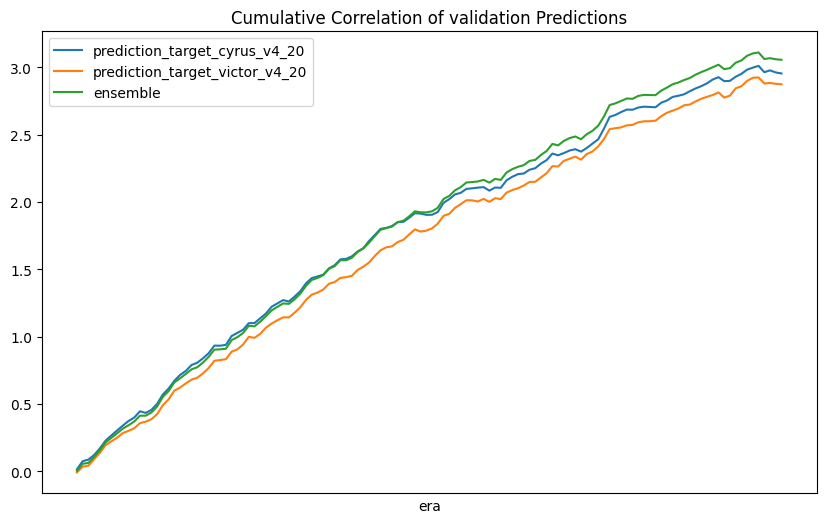

In [75]:
correlations = {}
cumulative_correlations = {}
for col in pred_cols:
    correlations[col] = validation.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of validation Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary metrics below, we can see that our ensemble seems to have better `mean`, `sharpe`, and `max_drawdown` than our original model which is great! 

In [76]:
summary_metrics = {}
for col in pred_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics).T
summary

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,0.023814,0.022222,1.071638,0.056556
prediction_target_victor_v4_20,0.023168,0.020852,1.111025,0.050773
ensemble,0.024633,0.021673,1.136564,0.054608


Looking at the results above, it seems like ensembling models trained on different targets can be a very fruitful avenue of research.

However, it is important to note that whether or not to create an ensemble is completely up to you. In fact, there are many great performing models that don't make use of the auxilliary targets at all.

If you are interested in learning more about targets, we highly encourage you to read up on these forum posts
- https://forum.numer.ai/t/how-to-ensemble-models/4034
- https://forum.numer.ai/t/target-jerome-is-dominating-and-thats-weird/6513

## 4. Model Upload
To wrap up this notebook, let's pickle and upload our ensemble.

As usual, we will be wrapping our submission pipeline into a function. Since we already have our favorite targets and trained models in memory, we can simply reference them in our function.  

In [77]:
def predict_ensemble(live_features: pd.DataFrame) -> pd.DataFrame:
    # generate predictions from each model
    predictions = pd.DataFrame(index=live_features.index)
    for target in favorite_targets:
        predictions[target] = models[target].predict(live_features[feature_cols])
    # ensemble predictions
    ensemble = predictions.rank(pct=True).mean(axis=1)
    # format submission
    submission = ensemble.rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [78]:
# Quick test
napi.download_dataset("v4.2/live_int8.parquet")
live_features = pd.read_parquet(f"v4.2/live_int8.parquet", columns=feature_cols)
predict_ensemble(live_features)

2023-08-30 17:32:52,748 INFO numerapi.utils: target file already exists
2023-08-30 17:32:52,749 INFO numerapi.utils: download complete


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,prediction
id,
n00011beb76fb85a,0.251835
n00030395c4ae306,0.805465
n00062925bf2d5a2,0.859910
n000af1f9814addb,0.317088
n001429f265846a1,0.056281
...,...
nffd6ffb0975a454,0.704527
nffe1891a18ae870,0.403548
nffe21a8f38193a1,0.265294


In [79]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_ensemble)
with open("predict_ensemble.pkl", "wb") as f:
    f.write(p)

In [80]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_ensemble.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model!